This notebook is used to compare the SNMR inversions produced using AarhusInv and the Vista Clara software

Neil Symington
Neil.Symington@ga.gov.au

In [1]:
%matplotlib inline

In [7]:
import netCDF4
import pandas as pd
import geopandas as gpd
import shapely
from shapely.geometry import Point
import numpy as np
import os
import matplotlib.pyplot as plt
import sqlalchemy as db
from sqlite3 import dbapi2 as sqlite
from geophys_utils._netcdf_point_utils import NetCDFPointUtils
from hydrogeol_utils import SNMR_utils, spatial_functions, AEM_utils

In [28]:
# Define function -- to move into repo when happy with result

def block_to_array(file):
    line = next(file)
    L = []
    while return_floats(line) is not None:
        L.append(return_floats(line))
        line = next(file)

    return np.array(L)

def return_floats(string):
    try:
        return [float(x) for x in string.split()]
    except ValueError:
        return None


def block_to_dataframe(file):
    line = next(file)
    header = line.strip().split()
    line = next(file)
    L = []
    while return_floats(line) is not None:
        L.append(return_floats(line))
        line = next(file)
    
    return pd.DataFrame(columns = header, data = np.array(L))

# Function for reformattign the 
def reformat_inversion_results(series):

    df_reformat = pd.DataFrame(columns = ['Depth_from', 'Depth_to',
                                                'Total_water_content','T2*','AEM_conductivity'])

    series
    # Find the number of layers

    n_layers = len([x for x in series.index if x.startswith("Res")])

    
    depth_from = 0.
    depth_to = series["Thic_#01"]
    
    # Iterate through the layers and 
    for i in range(1,n_layers+1):
        # Calculate/ extract layer 
        cond = 1./series["Res_#{:02d}".format(i)]
        wc = series["W_#{:02d}".format(i)]
        t2s = series["T2*_#{:02d}".format(i)]
        
        # Create a temporary dataframe to append
        df_temp = pd.DataFrame({'Depth_from': depth_from,
                               'Depth_to': depth_to,
                               'Total_water_content': wc,
                               "T2*": t2s,
                               "AEM_conductivity": cond},index = [i-1])
        df_reformat = df_reformat.append(df_temp)
        
        # Unless we are on the last layer update the depth top and bottom
        if i < n_layers:
            thickness = series["Thic_#{:02d}".format(i)]
            depth_from += thickness
            depth_to += thickness
    
    return df_reformat

def parse_AarhusInv_emo_files(emo_file):
    # Open the file
    
    with open(emo_file, 'r') as f:
        # Generator for yielding lines from .emo file
        line = next(f)
        # While there are still lines in the array
        while line:
            # Strip and split into a list
            L = line.strip().split()
           
            # Keyword for model misfits per iteration
            if L[0] == "Norm's":
                # Create a dataframe
                df_norms = block_to_dataframe(f)
            # Keyword for model parameters    
            if L[0] == "Parameters":
                line = next(f, None)
                header = line.strip().split()
                data = block_to_array(f)[:,1:]
                # Create dataframe with results per iteration
                df_params = pd.DataFrame(columns = header[:data.shape[1]],
                                        data = data)

            line = next(f, None)
        return {"model_parameters": df_params,
                "inversion_misfits": df_norms,
                "best_model": {"final_parameters": reformat_inversion_results(df_params.iloc[-1]),
                               "final_misfits": df_norms.iloc[-1]}}
            

def SNMR_comparison_plots(df1, df2, field_id, plot_doi = True, misfit = None,
                         savefig = False, fname = None):
    
    """
    df1: original SNMR data
    df2: interpolated SNMR data
    site_id: index of SNMR site join on
    
    """
    plt.close()
    fig, (ax1,ax2) = plt.subplots(1,2, sharey=True, figsize = (8,6))
    
    df1_site = df1[df1['Field_ID']==field_id]
    
    df2_site = df2[df2['Field_ID']==field_id]
    
    if plot_doi: 
    
        doi = df1_site['Depth_of_Investigation'].unique()[0]    
    
    ax1 = SNMR_utils.plot_profile(ax1, df1_site,
                             doi = doi, plot_mobile_water = True)
    
    ax2 = SNMR_utils.plot_profile(ax2, df2_site,
                             doi = doi)
    

    ax1.set_title("SNMR inversion Vista Clara")
    ax2.set_title("SNMR inversion AarhusInv - misfit = " + str(misfit))

    ax1.set_ylim([0,np.max(df1_site['Depth_to'] + 
                          0.2*np.max(df1_site['Depth_to']))])

    plt.gca().invert_yaxis()
    
    if savefig:
        plt.savefig(fname)
    else:
        plt.show()

In [15]:
# Next we want to add other data over the conductivity sections

# Import SNMR data

# Connect to the SNMR database

DB_PATH = r"\\prod.lan\active\proj\futurex\East_Kimberley\Data\Processed\Geophysics\NMR\SNMR\East_Kimberley_SNMR.sqlite"
        
engine = db.create_engine('sqlite:///' + DB_PATH, module=sqlite)

connection = engine.connect()


Field_IDs = [field_id]

# Create a SQL query
placeholder = '?'  # For SQLite. See DBAPI paramstyle.
placeholders = ', '.join(placeholder * len(Field_IDs))

query = """

SELECT
              s.site_id,
              s.Field_ID,
              a.acquisition_id,
              a.pulse_sequence,
              a.pulse_length,
              imm.Depth_of_Investigation
              
FROM 

             sites as s
             JOIN acquisitions as a on s.site_id=a.site_id
             JOIN inverse_model_metadata as imm on a.acquisition_id = imm.acquisition_id

WHERE

            a.pulse_sequence == "FID"

"""

df_acquisitions = pd.read_sql_query(query, connection, index_col = 'acquisition_id')

# Extract the inversion table for these acquisitions

acquisition_ids = df_acquisitions.index

cols = ['Depth_from', 'Depth_to', 'Mobile_water_content', 'Bound_water_content',
       'Total_water_content', 'T2*', 'site_id', 'acquisition_id', 'inversion_id']

df_inversions= SNMR_utils.extract_snmr_inversions(acquisition_ids, connection,
                                                  mask_below_doi = False)[cols]


# Join the SNMR inversions on acquisition and sites

df_inversions = df_inversions.merge(df_acquisitions, how='inner', left_on='acquisition_id',
                                    right_index=True)

In [16]:
df_inversions

,Depth_from,Depth_to,Mobile_water_content,Bound_water_content,Total_water_content,T2*,site_id_x,acquisition_id,inversion_id,site_id_y,Field_ID,pulse_sequence,pulse_length,Depth_of_Investigation
table_id,,,,,,,,,,,,,,
0,0.417808,0.592321,0.000000,0.000000,0.000000,0.231000,0,0,0,0,MillProf,FID,40.0,45.148358
1,0.592321,0.809702,0.000000,0.001461,0.001461,0.010260,0,0,0,0,MillProf,FID,40.0,45.148358
2,0.809702,1.074661,0.000739,0.000076,0.000815,0.022904,0,0,0,0,MillProf,FID,40.0,45.148358
3,1.074661,1.391905,0.000000,0.001571,0.001571,0.010260,0,0,0,0,MillProf,FID,40.0,45.148358
4,1.391905,1.766143,0.000000,0.001880,0.001880,0.012669,0,0,0,0,MillProf,FID,40.0,45.148358
5,1.766143,2.202083,0.001542,0.000000,0.001542,0.128101,0,0,0,0,MillProf,FID,40.0,45.148358
6,2.202083,2.704433,0.000000,0.000000,0.000000,2.996982,0,0,0,0,MillProf,FID,40.0,45.148358
7,2.704433,3.277902,0.000000,0.000000,0.000000,2.997264,0,0,0,0,MillProf,FID,40.0,45.148358
8,3.277902,3.927197,0.000251,0.004860,0.005111,0.028796,0,0,0,0,MillProf,FID,40.0,45.148358


C:\Users\u77932\AppData\Local\Continuum\anaconda3\envs\hydrogeol_utils\lib\site-packages\ipykernel_launcher.py:36: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


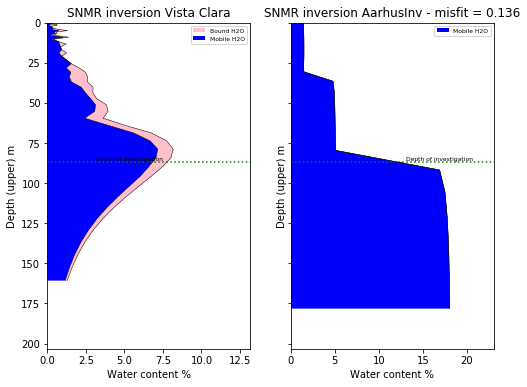

In [46]:
# Iterate through all the directories and find the .emo files

rootDir  = r"\\prod.lan\active\proj\futurex\East_Kimberley\Working\Neil\SNMR_aarhusInv\output_very_sharp"

outdir = os.path.join(rootDir, 'comparison_plots')

if not os.path.exists(outdir):
    os.mkdir(outdir)
    
for dirName, subdirList, fileList in os.walk(rootDir):
    for fname in fileList:
        if fname.endswith('.emo'):
            emo_file = os. path.join(dirName, fname)
            # Extract the field id from the filename
            field_id =  '_'.join(emo_file.split("\\")[-2].split('_')[:-1])
            # Extract the inversion parameters from the filename
            pulse_length = float(fname.split('ms_')[0])
            
            # Extract data from Aarhus inv survey
            SNMR_inversion_dict = parse_AarhusInv_emo_files(emo_file)
            
            df_model_params = SNMR_inversion_dict["best_model"]["final_parameters"]

            df_model_params['Field_ID'] = field_id
            
            misfit = SNMR_inversion_dict['best_model']['final_misfits']['Data']
            
            #Extract the data from the Vista Clara survey
            # Set criteria based on field id
            criterion1 = df_inversions.Field_ID.map(lambda x: x == field_id)
            
            # Set criteria based on pulse length
            criterion2 = df_inversions.pulse_length.map(lambda x:x == pulse_length)
            
            # Extract
            df_inversion = df_inversions[criterion1][criterion2]
            
            # Define filename
            suffix =  '_FID_' + str(pulse_length) + '_ms_comparison_plots.png'
            
            outfname = os.path.join(outdir, field_id + suffix)
            
            # Unless there are no comparison plots then output comparison plots
            if len(df_inversion) > 0:
                SNMR_comparison_plots(df_inversion, df_model_params, 
                                      field_id = field_id, plot_doi =True,
                                      misfit = misfit,
                                     savefig = True, fname = outfname)
            
            